# Problem Set 4

In [1]:
#Let there be np.light
import numpy as np
import pylab as plt
import pickle as pkl
import scipy.optimize

In [2]:
#Extracting data
# Dear all: Get this pickle file from the discord server!
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`

In [ ]:
#Constructing fitter
def designfit(x_array,y_array,sigma_array,*design):
    N = len(design) #number of variational parameters
    
    #Creating (transposed) design matrix
    A = [model(x_array) for model in design]
    
    #Creating the NxN M_x coefficient matrix
    M_x = np.array([[np.sum(A[i]*sigma_array**(-2)*A[j]) for j in range(N)] for i in range(N)])
    
    #Creating the Nx1 M_y ordinate vector
    M_y = np.array([np.sum(A[i]*sigma_array**(-2)*y_array) for i in range(N)])
    
    #Solving for fit parameters. 
    return (np.linalg.solve(M_x,M_y))

## Problem 1

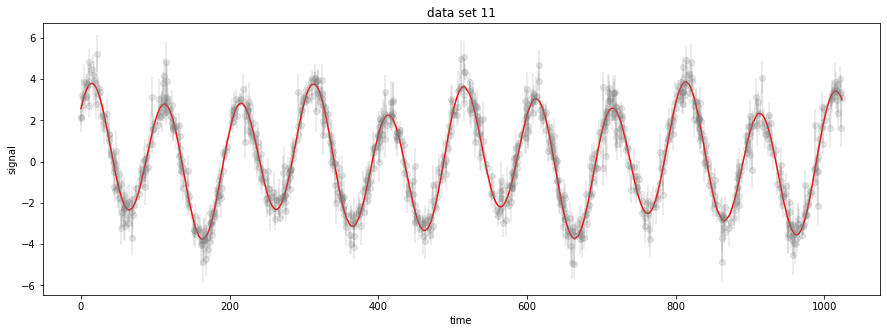

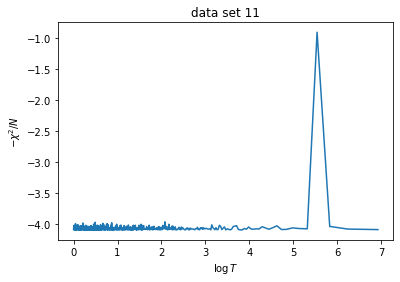

In [55]:
#Design 2 (100-day signal + one more signal)

#Knobs
sample_step = 1
data_set_index = 12

#Defining functions
identity = lambda x: 1
cos100 = lambda x : np.cos((2*np.pi/100)*x)
sin100 = lambda x : np.sin((2*np.pi/100)*x)

#Getting best-fits, chi-squared values, and plots
chisq2 = []

#Setting up log likelihood sample space
total_time = int(max(data[0])-min(data[0]))
freq_samples = np.arange(sample_step,len(data[0])+sample_step,sample_step)/total_time
neg_chisq = []

#Exploring the parameter space
for f in freq_samples:
    sinvar = lambda x : np.sin(2*np.pi*f*x)
    cosvar = lambda x : np.cos(2*np.pi*f*x)

    par_vals2 = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvar,sinvar)

    y_pred_vals = par_vals2[0]*cos100(data[0]) + par_vals2[1]*sin100(data[0]) + par_vals2[2] + par_vals2[3]*cosvar(data[0]) + par_vals2[4]*sinvar(data[0])
    delta_y = data[data_set_index] - y_pred_vals
    neg_chisq.append(-np.sum(delta_y*data[1]**(-2)*delta_y))

#Setting initial guesses for parameter optimization
freq_best_guess = freq_samples[neg_chisq.index(max(neg_chisq))]
sinvarbest = lambda x : np.sin(2*np.pi*freq_best_guess*x)
cosvarbest = lambda x : np.cos(2*np.pi*freq_best_guess*x)
par_vals2_best_guess = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvarbest,sinvarbest)

#Defining functions
sinvarf = lambda x,f : np.sin(2*np.pi*f*x)
cosvarf = lambda x,f : np.cos(2*np.pi*f*x)
yfit_func = lambda x : x[0]*cos100(data[0]) + x[1]*sin100(data[0]) + x[2] + x[3]*cosvarf(data[0],x[5]) + x[4]*sinvarf(data[0],x[5])
chisq_func = lambda x : np.sum((data[data_set_index]-yfit_func(x))*data[1]**(-2)*(data[data_set_index]-yfit_func(x)))

#Initial guess for optimum parameter values
guess = np.array(list(par_vals2_best_guess) + [freq_best_guess])

#Getting best fit
bestfit_vals_data11 = scipy.optimize.minimize(chisq_func,guess,method='Nelder-Mead').x
y_bestfit_vals = yfit_func(bestfit_vals)

#Collecting chi-squared values
chisq2.append(np.sum((data[data_set_index]-y_bestfit_vals)*data[1]**(-2)*(data[data_set_index]-y_bestfit_vals)))

#Plotting
plt.figure(figsize=(15, 5))
plt.errorbar(data[0], data[data_set_index], yerr=data[1],
             color="gray", marker="o", alpha=0.2)
plt.plot(data[0],y_bestfit_vals,color='red')
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set {}".format(data_set_index-1))
plt.show()

plt.plot(-np.log(freq_samples),np.array(neg_chisq)/len(data[0]))
plt.ylabel('$-\chi^2/N$')
plt.xlabel('$\log T$')
plt.title(f'data set {data_set_index-1}')
plt.show()

In [56]:
#Bootstrap

bootstrap_samples = 20
data_set_index = 12

bootstrap_set = []
amplitude_set100 = np.random.rand(bootstrap_samples)
amplitude_set = np.random.rand(bootstrap_samples)

for boot_samp in range(bootstrap_samples):
    data_set_sample = np.array([data[:,int(np.random.random_sample()*len(data[0]))] for i in range(len(data[0]))]).transpose()

    freq_samples = np.arange(sample_step,len(data[0])+sample_step,sample_step)/total_time
    neg_chisq = []

    for f in freq_samples:
        sinvar = lambda x : np.sin(2*np.pi*f*x)
        cosvar = lambda x : np.cos(2*np.pi*f*x)

        par_vals2 = designfit(data_set_sample[0],data_set_sample[data_set_index],data_set_sample[1],cos100,sin100,identity,cosvar,sinvar)

        y_pred_vals = par_vals2[0]*cos100(data_set_sample[0]) + par_vals2[1]*sin100(data_set_sample[0]) + par_vals2[2] + par_vals2[3]*cosvar(data_set_sample[0]) + par_vals2[4]*sinvar(data_set_sample[0])
        delta_y = y_pred_vals - data_set_sample[data_set_index]
        neg_chisq.append(-np.sum(delta_y*data_set_sample[1]**(-2)*delta_y)/2)

    #Setting initial guesses for parameter optimization
    freq_best_guess = freq_samples[neg_chisq.index(max(neg_chisq))]
    sinvarbest = lambda x : np.sin(2*np.pi*freq_best_guess*x)
    cosvarbest = lambda x : np.cos(2*np.pi*freq_best_guess*x)
    par_vals2_best_guess = designfit(data_set_sample[0],data_set_sample[data_set_index],data_set_sample[1],cos100,sin100,identity,cosvarbest,sinvarbest)

    #Defining functions
    sinvarf = lambda x,f : np.sin(2*np.pi*f*x)
    cosvarf = lambda x,f : np.cos(2*np.pi*f*x)
    yfit_func = lambda x : x[0]*cos100(data_set_sample[0]) + x[1]*sin100(data_set_sample[0]) + x[2] + x[3]*cosvarf(data_set_sample[0],x[5]) + x[4]*sinvarf(data_set_sample[0],x[5])
    chisq_func = lambda x : np.sum((data_set_sample[data_set_index]-yfit_func(x))*data_set_sample[1]**(-2)*(data_set_sample[data_set_index]-yfit_func(x)))

    #Initial guess for optimum parameter values
    guess = np.array(list(par_vals2_best_guess) + [freq_best_guess])

    #Getting best fit
    bestfit_vals = scipy.optimize.minimize(chisq_func,guess,method='Nelder-Mead').x
    bootstrap_set.append(bestfit_vals)
    print(f'{boot_samp+1}/{bootstrap_samples}')

bootstrap_set = np.array(bootstrap_set)
variances = [np.var(bootstrap_set[:,i]) for i in range(len(bootstrap_set[0]))]

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


In [58]:

print(T_max,T_min)

def T_prior(T):
    

1023 0.9990234375


In [98]:
#Constructing ln(posterior) function

##ln(likelihood) function
sinvarT = lambda x,T : np.sin(2*np.pi*x/T)
cosvarT = lambda x,T : np.cos(2*np.pi*x/T)
yfit_func = lambda x : x[0]*cos100(data_set_sample[0]) + x[1]*sin100(data_set_sample[0]) + x[2] + x[3]*cosvarf(data_set_sample[0],x[5]) + x[4]*sinvarf(data_set_sample[0],x[5])
chisq_func = lambda x : np.sum((data_set_sample[data_set_index]-yfit_func(x))*data_set_sample[1]**(-2)*(data_set_sample[data_set_index]-yfit_func(x)))

##ln(period prior)
T_max, T_min = total_time, total_time/len(data[0])
def ln_T_prior(T):
    if T < T_min or T > T_max:
        return -np.inf
    else:
        return -np.log(T)

def ln_posterior(x):
    output = -1/2*chisq_func(x) #ln(likelihood)
    for i in range(len(bestfit_vals)-1):
        output += -(x[i]-bestfit_vals[i])**2/(2*variances[i]) #ln(amp priors)
    output += ln_T_prior(x[-1]) #ln(period prior)
    return output

#Creating MHMCMC sampler
def ln_mhmcmc(f,x0,samples,prop_cov):
    output = [x0]
    current_x = x0
    
    for sample in range(samples-1):
        prop_x = np.random.multivariate_normal(current_x,prop_cov)
        
        if f(prop_x) - f(current_x) >= np.log(np.random.rand()):
            current_x = prop_x
            
        output.append(current_x)
    
    return np.array(output)

In [108]:
points = ln_mhmcmc(ln_posterior,initial*0.8,10000,np.identity(6))
print(np.shape(points))

(10000, 6)


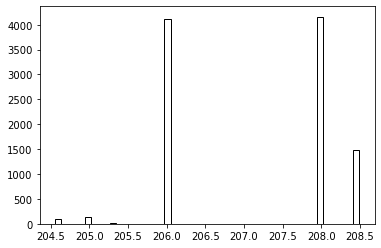

256.23089659358357


In [135]:
i = 5
plt.hist(points[:,i],density=False,bins=50,histtype='step',color='black')
# plt.plot(np.linspace(-4,4,100),gaussian1D(np.linspace(-4,4,100),0,2),color='red')
# plt.title('Normed histogram in $x$')
# plt.xlabel('$x$')
plt.show()
print(initial[i])

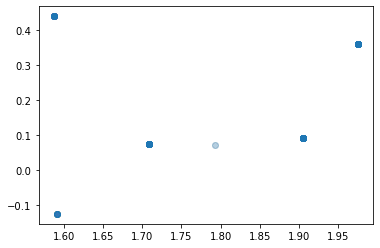

In [126]:
plt.scatter(points[:,0],points[:,3], alpha=0.02)
plt.show()

## Problem 2

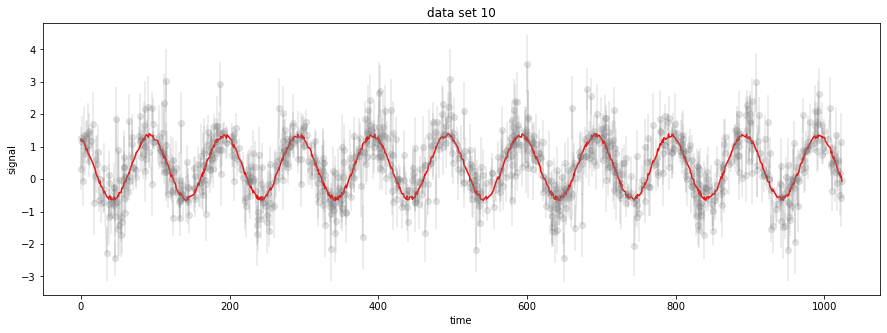

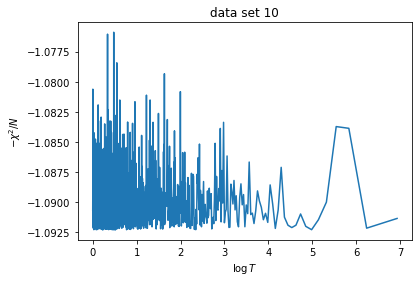

In [4]:
#Design 2 (100-day signal + one more signal)

#Knobs
sample_step = 1
data_set_index = 11

#Defining functions
identity = lambda x: 1
cos100 = lambda x : np.cos((2*np.pi/100)*x)
sin100 = lambda x : np.sin((2*np.pi/100)*x)

#Getting best-fits, chi-squared values, and plots
chisq2 = []

#Setting up log likelihood sample space
total_time = int(max(data[0])-min(data[0]))
freq_samples = np.arange(sample_step,total_time+sample_step,sample_step)/total_time
neg_chisq = []

#Exploring the parameter space
for f in freq_samples:
    sinvar = lambda x : np.sin(2*np.pi*f*x)
    cosvar = lambda x : np.cos(2*np.pi*f*x)

    par_vals2 = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvar,sinvar)

    y_pred_vals = par_vals2[0]*cos100(data[0]) + par_vals2[1]*sin100(data[0]) + par_vals2[2] + par_vals2[3]*cosvar(data[0]) + par_vals2[4]*sinvar(data[0])
    delta_y = data[data_set_index] - y_pred_vals
    neg_chisq.append(-np.sum(delta_y*data[1]**(-2)*delta_y))

#Setting initial guesses for parameter optimization
freq_best_guess = freq_samples[neg_chisq.index(max(neg_chisq))]
sinvarbest = lambda x : np.sin(2*np.pi*freq_best_guess*x)
cosvarbest = lambda x : np.cos(2*np.pi*freq_best_guess*x)
par_vals2_best_guess = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvarbest,sinvarbest)

#Defining functions
sinvarf = lambda x,f : np.sin(2*np.pi*f*x)
cosvarf = lambda x,f : np.cos(2*np.pi*f*x)
yfit_func = lambda x : x[0]*cos100(data[0]) + x[1]*sin100(data[0]) + x[2] + x[3]*cosvarf(data[0],x[5]) + x[4]*sinvarf(data[0],x[5])
chisq_func = lambda x : np.sum((data[data_set_index]-yfit_func(x))*data[1]**(-2)*(data[data_set_index]-yfit_func(x)))

#Initial guess for optimum parameter values
guess = np.array(list(par_vals2_best_guess) + [freq_best_guess])

#Getting best fit
bestfit_vals = scipy.optimize.minimize(chisq_func,guess,method='Nelder-Mead').x
y_bestfit_vals = yfit_func(bestfit_vals)

#Collecting chi-squared values
chisq2.append(np.sum((data[data_set_index]-y_bestfit_vals)*data[1]**(-2)*(data[data_set_index]-y_bestfit_vals)))

#Plotting
plt.figure(figsize=(15, 5))
plt.errorbar(data[0], data[data_set_index], yerr=data[1],
             color="gray", marker="o", alpha=0.2)
plt.plot(data[0],y_bestfit_vals,color='red')
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set {}".format(data_set_index-1))
plt.show()

plt.plot(-np.log(freq_samples),np.array(neg_chisq)/len(data[0]))
plt.ylabel('$-\chi^2/N$')
plt.xlabel('$\log T$')
plt.title(f'data set {data_set_index-1}')
plt.show()

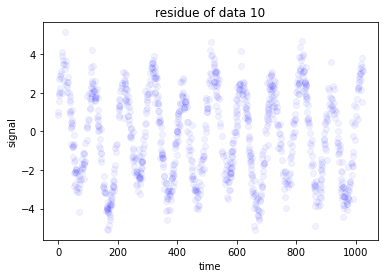

In [5]:
#Getting residue and plotting
residue10 = data[12]-y_bestfit_vals
plt.plot(data[0],residue10,'bo',alpha=0.05)
plt.xlabel('time')
plt.ylabel('signal')
plt.title(f'residue of data 10')
plt.show()

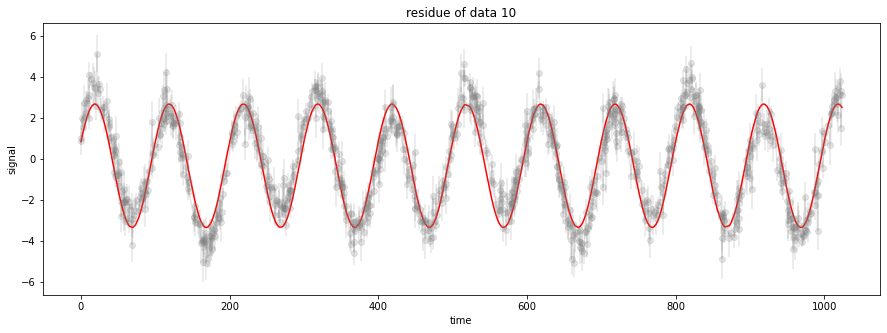

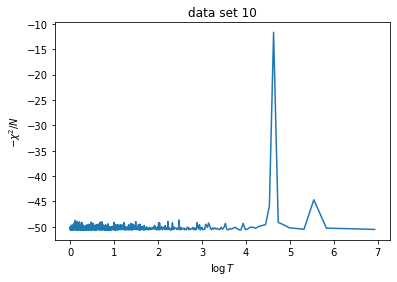

In [6]:
#Getting period of residue10

#Knobs
sample_step = 1

#Getting best-fits, chi-squared values, and plots
chisq2 = []

#Setting up log likelihood sample space
total_time = int(max(data[0])-min(data[0]))
freq_samples = np.arange(sample_step,total_time+sample_step,sample_step)/total_time
neg_chisq = []

#Exploring the parameter space
for f in freq_samples:
    sinvar = lambda x : np.sin(2*np.pi*f*x)
    cosvar = lambda x : np.cos(2*np.pi*f*x)

    par_vals2 = designfit(data[0],residue10,data[1],identity,cosvar,sinvar)

    Ry_pred_vals = par_vals2[0] + par_vals2[1]*cosvar(data[0]) + par_vals2[2]*sinvar(data[0])
    delta_y = residue10 - Ry_pred_vals
    neg_chisq.append(-np.sum(delta_y*data[1]**(-2)*delta_y))

#Setting initial guesses for parameter optimization
freq_best_guess = freq_samples[neg_chisq.index(max(neg_chisq))]
sinvarbest = lambda x : np.sin(2*np.pi*freq_best_guess*x)
cosvarbest = lambda x : np.cos(2*np.pi*freq_best_guess*x)
par_vals2_best_guess = designfit(data[0],residue10,data[1],identity,cosvarbest,sinvarbest)

#Defining functions
sinvarf = lambda x,f : np.sin(2*np.pi*f*x)
cosvarf = lambda x,f : np.cos(2*np.pi*f*x)
yfit_func = lambda x : x[0] + x[1]*cosvarf(data[0],x[3]) + x[2]*sinvarf(data[0],x[3])
chisq_func = lambda x : np.sum((residue10-yfit_func(x))*data[1]**(-2)*(residue10-yfit_func(x)))

#Initial guess for optimum parameter values
guess = np.array(list(par_vals2_best_guess) + [freq_best_guess])

#Getting best fit
bestfit_vals = scipy.optimize.minimize(chisq_func,guess,method='Nelder-Mead').x
y_bestfit_vals = yfit_func(bestfit_vals)

#Collecting chi-squared values
chisq2.append(np.sum((data[data_set_index]-y_bestfit_vals)*data[1]**(-2)*(data[data_set_index]-y_bestfit_vals)))

#Plotting
plt.figure(figsize=(15, 5))
plt.errorbar(data[0], residue10, yerr=data[1],
             color="gray", marker="o", alpha=0.2)
plt.plot(data[0],y_bestfit_vals,color='red')
plt.xlabel("time")
plt.ylabel("signal")
plt.title("residue of data 10")
plt.show()

plt.plot(-np.log(freq_samples),np.array(neg_chisq)/len(data[0]))
plt.ylabel('$-\chi^2/N$')
plt.xlabel('$\log T$')
plt.title(f'data set {data_set_index-1}')
plt.show()

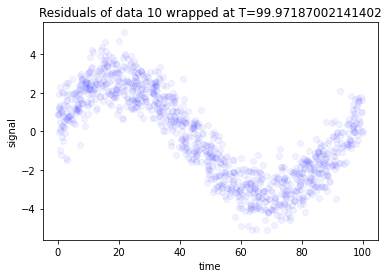

In [8]:
#Wrapping residue 10 at its best-fit period
second_T = 1/bestfit_vals[3]
plt.plot(data[0]%second_T,residue10,'bo',alpha=0.05)
plt.xlabel('time')
plt.ylabel('signal')
plt.title(f'Residuals of data 10 wrapped at T={second_T}')
plt.show()

**From the plot above, we see that the candidate second signal has a very persitent period.**

## Problem 3